## Network Analysis of Antimalarial Drug Supply Chains in Ghana
This notebook analyze the Ghana antimalarial drugs supply data. 

Data from Cape Coast University survey Adams Osman. It comprises surveys of various medical supply outletsy, OTC (over the counter), registered Pharmacy and registered suppliers.  

Survey was conducted by visiting a selection of phasrmacies and OTCs, asking about their supplier, then visiting that supplier.  Suppliers of suppliers were not visited.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium
from folium.plugins import MiniMap
from folium.plugins import FloatImage
from folium import GeoJson
import collections
import pandas as pd
import seaborn as sns
import scipy.stats

In [2]:
#Some cells generate long warnings but doesn't seem to affect the result
#Could be disabled
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read pharmacy data from CSV file
pharmacy_data = pd.read_csv('Retailers_Suppliers1_Suppliers2_Final_Edit(1).csv')
pharmacy_data = pharmacy_data.fillna(0) #Fill NAN entries with zeros
pharmacy_data

OID_  DI     Infor  latitude  longitude  Codes  \
0    114.0  F1  Pharmacy  6.686896  -1.607081      1   
1     64.0  F2  Pharmacy  6.670298  -1.590986      2   
2     94.0  F3       OTC  6.751693  -1.603975      3   
3     68.0  F4       OTC  6.705169  -1.618656      4   
4     37.0  F5       OTC  6.722547  -1.604707      5   
..     ...  ..       ...       ...        ...    ...   
224    0.0   0  Supplier  5.626706   0.005751    225   
225    0.0   0  Supplier  5.879465   0.174839    226   
226    0.0   0  Supplier  5.564263  -0.220263    227   
227    0.0   0  Supplier  5.879465   0.174839    228   
228    0.0   0  Supplier  5.575025  -0.211214    229   

                             A7_Organisation_Name     S1     S2   S3     S4  \
0                                    MEK PHARMACY  168.0    0.0  0.0    0.0   
1                              Kwik save pharmacy  147.0  140.0  0.0  147.0   
2    David Akuoku Over the counter chemical store  185.0  171.0  0.0  129.0   
3                                  Aderic Chemist  181.0    0.0  0.0  181.0   
4                                 Rukaya Omar otc  171.0    0.0  0.0  171.0   
..                                            ...    ...    ...  ...    ...   
224                            Mystery Supplier 3    0.0    0.0  0.0    0.0   
225             Life Science Pharma limited_Accra    0.0    0.0  0.0    0.0   
226                        Eskay Therapeutics Ltd    0.0    0.0  0.0    0.0   
227                           Life Sciences_Accra    0.0    0.0  0.0    0.0   
228          Amponsah Effah Pharmaceuticals_Accra    0.0    0.0  0.0    0.0   

      S5   S6     S7   S8   S9  
0    0.0  0.0    0.0  0.0  0.0  
1    0.0  0.0  147.0  0.0  0.0  
2    0.0  0.0    0.0  0.0  0.0  
3    0.0  0.0    0.0  0.0  0.0  
4    0.0  0.0    0.0  0.0  0.0  
..   ...  ...    ...  ...  ...  
224  0.0  0.0    0.0  0.0  0.0  
225  0.0  0.0    0.0  0.0  0.0  
226  0.0  0.0    0.0  0.0  0.0  
227  0.0  0.0    0.0  0.0  0.0  
228  0.0  0.0    0.0  0.0  0.0  

[229 rows x 16 columns]

In [4]:
#This is the unmodified spreadsheet with (0,0) locations not filled in
#A seperate dataframe for diaplaying surveyed outlet locations
pharmacy_data_original = pd.read_csv('Retailers_Suppliers1_Suppliers2_Final_Edit.csv')  
pharmacy_data_original = pharmacy_data_original.fillna(0)
mask = (pharmacy_data_original['longitude'] != 0) & (pharmacy_data_original['latitude'] != 0) 
sample = pharmacy_data_original[mask]
sample

OID_   DI     Infor  latitude  longitude  Codes  \
0    114.0   F1  Pharmacy  6.686896  -1.607081      1   
1     64.0   F2  Pharmacy  6.670298  -1.590986      2   
2     94.0   F3       OTC  6.751693  -1.603975      3   
3     68.0   F4       OTC  6.705169  -1.618656      4   
4     37.0   F5       OTC  6.722547  -1.604707      5   
..     ...  ...       ...       ...        ...    ...   
190   58.0  R69  Supplier  5.690240  -0.030330    191   
191   65.0  R78  Supplier  9.395851  -0.846761    192   
192   67.0  R81  Supplier  5.633900  -0.172560    193   
193   15.0  R26  Supplier  5.561620  -0.213670    194   
195   45.0  R55  Supplier  5.547380  -0.209800    196   

                             A7_Organisation_Name     S1     S2     S3     S4  \
0                                    MEK PHARMACY  168.0    0.0    0.0    0.0   
1                              Kwik save pharmacy  147.0  140.0    0.0  147.0   
2    David Akuoku Over the counter chemical store  185.0  171.0    0.0  129.0   
3                                  Aderic Chemist  181.0    0.0    0.0  181.0   
4                                 Rukaya Omar otc  171.0    0.0    0.0  171.0   
..                                            ...    ...    ...    ...    ...   
190                         Widama Pharmacy_Accra    0.0    0.0    0.0    0.0   
191                     Ernest Chemist Ltd_Tamale  138.0    0.0    0.0    0.0   
192              Ernest Chemist Ltd_Accra_Shiashi  138.0    0.0    0.0    0.0   
193                               Kelmed Pharmacy  218.0  137.0  214.0  138.0   
195                             Shagysco Pharmacy  206.0    0.0    0.0    0.0   

      S5   S6     S7   S8   S9  
0    0.0  0.0    0.0  0.0  0.0  
1    0.0  0.0  147.0  0.0  0.0  
2    0.0  0.0    0.0  0.0  0.0  
3    0.0  0.0    0.0  0.0  0.0  
4    0.0  0.0    0.0  0.0  0.0  
..   ...  ...    ...  ...  ...  
190  0.0  0.0    0.0  0.0  0.0  
191  0.0  0.0    0.0  0.0  0.0  
192  0.0  0.0    0.0  0.0  0.0  
193  0.0  0.0    0.0  0.0  0.0  
195  0.0  0.0    0.0  0.0  0.0  

[189 rows x 16 columns]

## Build Networkx objects ##

Construct the networkx directed Graph object G from the dataframe and add the nodes and links. 

In [5]:
xxxx=pharmacy_data['Infor']
#  G is the main object we work with, a networkx directed Graph object
G=nx.DiGraph()
#reference numbers for each supplier/retailer
codex = np.array(pharmacy_data['Codes']).astype(int)
#  Make separate lists of the suppliers refernece numbers as integers
s1x=np.array(pharmacy_data['S1']).astype(int)
s2x=np.array(pharmacy_data['S2']).astype(int)
s3x=np.array(pharmacy_data['S3']).astype(int)
s4x=np.array(pharmacy_data['S4']).astype(int)
s5x=np.array(pharmacy_data['S5']).astype(int)
s6x=np.array(pharmacy_data['S6']).astype(int)
s7x=np.array(pharmacy_data['S7']).astype(int)
s8x=np.array(pharmacy_data['S8']).astype(int)
s9x=np.array(pharmacy_data['S9']).astype(int)

#pack the logitude and latitude columns 
longlat=np.column_stack((pharmacy_data['longitude'],pharmacy_data['latitude']))
G.add_nodes_from(codex) 
#put longlat into dictionary so the positions can be accessed by the code and not the index(avoid the annoying -1)
positions = dict(zip(G.nodes, longlat)) 

In [6]:
xlist = [s1x, s2x, s3x, s4x, s5x, s6x, s7x, s8x, s9x]

In [7]:
#  Place edges between supplier and retailers
for nodes in range(codex.size): 
    for i in xlist:
        x = i[nodes]
        if x!=0 : 
            G.add_edge(codex[nodes],x)

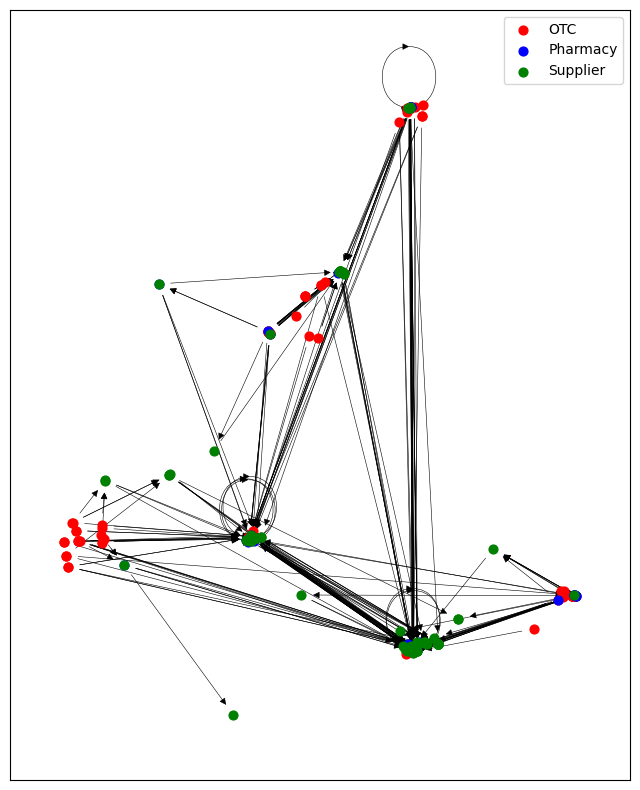

In [8]:
#Draw the Graph
plt.rcParams["figure.figsize"] = (8,10)
nx.draw_networkx_nodes(G, positions, nodelist=codex[xxxx=='OTC'], node_color="red",node_size=40, label='OTC')
nx.draw_networkx_nodes(G, positions, nodelist=codex[xxxx=='Pharmacy'], node_color="blue",node_size=40, label='Pharmacy')
nx.draw_networkx_nodes(G, positions, nodelist=codex[xxxx=='Supplier'], node_color="green",node_size=40, label='Supplier')

nx.draw_networkx_edges(G, positions, width = 0.4)

plt.legend()
plt.show()

## Create map with retailer/supplier locations
Using folium to create an interactive map with locations of the retailer/suppliers for better visulization of the network.

In [9]:
#read geojson file containing border coordinates for Ghana
geo = r"ghana.geojson"
file = open(geo, encoding="utf8")
text = file.read()

First create a map to show the visited retailers/suppliers location, to visulize the distribution of the samples across Ghana

In [10]:
# Plotting locations of the retailers/suppliers surveyed using original datafrme pharmacy_data_original
# Create map centered on Ghana
ghana_map = folium.Map(location=[7.9465, -1.0232], zoom_start=6)
#add Ghana border
GeoJson(text,
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'black',  
        'weight': 1.5    
    }).add_to(ghana_map)

#add legend to map(as a image)
image_file = 'legend.png'
FloatImage(image_file, bottom=1, left=1).add_to(ghana_map)
#add a minimap 
minimap = MiniMap(position='topright', width=150, height=150)
ghana_map.add_child(minimap)
    
# Add markers for each OTC location
for index, row in (sample[sample['Infor'] == 'OTC']).iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']], 
                        color = 'red', radius =4.5, fill = True, fill_opacity = 0.6, 
                        popup=row['A7_Organisation_Name']).add_to(ghana_map)
    
# Add markers for each pharmacy location
for index, row in (sample[sample['Infor'] == 'Pharmacy']).iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']], 
                           color = 'blue', radius =4.5, fill = True, fill_opacity = 0.6,
                           popup=row['A7_Organisation_Name']).add_to(ghana_map)
    
# Add markers for each supplier location
for index, row in (sample[sample['Infor'] == 'Supplier']).iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']], 
                           color = 'green', radius =4.5, fill = True, fill_opacity = 0.6,
                           popup=row['A7_Organisation_Name']).add_to(ghana_map)
ghana_map

Now the map for the whole network

In [11]:
# Create map centered on Ghana
ghana_map = folium.Map(location=[7.9465, -1.0232], zoom_start=6)  

edges = list(G.edges()) 
latlong = [(b, a) for (a, b) in longlat] 
latlong = dict(zip(G.nodes, latlong))
for edge in edges:
    folium.PolyLine(locations=[latlong[edge[0]], latlong[edge[1]]], color='black', weight=.4).add_to(ghana_map)
    
# Add markers for each OTC location
for index, row in (pharmacy_data[pharmacy_data['Infor'] == 'OTC']).iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']], 
                        color = 'red', radius =3, fill = True, fill_opacity = 0.6, 
                        popup=row['A7_Organisation_Name']).add_to(ghana_map)
    
# Add markers for each pharmacy location
for index, row in (pharmacy_data[pharmacy_data['Infor'] == 'Pharmacy']).iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']], 
                           color = 'blue', radius =3, fill = True, fill_opacity = 0.6,
                           popup=row['A7_Organisation_Name']).add_to(ghana_map)
    
# Add markers for each supplier location
for index, row in (pharmacy_data[pharmacy_data['Infor'] == 'Supplier']).iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']], 
                           color = 'green', radius =3, fill = True, fill_opacity = 0.6,
                           popup=row['A7_Organisation_Name']).add_to(ghana_map)
    
FloatImage(image_file, bottom=1, left=1).add_to(ghana_map)
    
ghana_map

Just another version with different markers and cute icons

In [12]:
# Create map centered on Ghana
ghana_map = folium.Map(location=[7.9465, -1.0232], zoom_start=6)
    
# Add markers for each OTC location
for index, row in (pharmacy_data[pharmacy_data['Infor'] == 'OTC']).iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], 
                           icon=folium.Icon(color='red', icon = 'prescription-bottle-medical',  prefix='fa'),
                           popup=row['A7_Organisation_Name']).add_to(ghana_map)
    
# Add markers for each supplier location
for index, row in (pharmacy_data[pharmacy_data['Infor'] == 'Supplier']).iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], 
                           icon=folium.Icon(color='green', icon = 'truck-field', prefix='fa'),
                           popup=row['A7_Organisation_Name']).add_to(ghana_map)

# Add markers for each pharmacy location
for index, row in (pharmacy_data[pharmacy_data['Infor'] == 'Pharmacy']).iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], 
                           icon=folium.Icon(color='blue', icon = 'prescription-bottle-medical', prefix='fa'),
                           popup=row['A7_Organisation_Name']).add_to(ghana_map)
    
#Add polylines between the locations
edges = list(G.edges()) #list of edges
latlong = [(b, a) for (a, b) in longlat] 
latlong = dict(zip(G.nodes, latlong))
for edge in edges:
    folium.PolyLine(locations=[latlong[edge[0]], latlong[edge[1]]], color='black', weight=.7).add_to(ghana_map)
    
minimap = MiniMap(position='topright', width=150, height=150)
ghana_map.add_child(minimap)
FloatImage(image_file, bottom=1, left=1).add_to(ghana_map)

In [13]:
ghana_map

## Adjacency Matrix ##
Here we build the adjacency for the whole network (229*229)

In [14]:
am = nx.adjacency_matrix(G)
am = am.todense()
am

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [15]:
#Calculate number of links from a node
def linkfrom(node):
    return np.sum(am[node-1, :])
linkfrom(183)

0

In [16]:
#Calculate number of links to a node
def linkto(node):
    return np.sum(am[: , node-1])
linkto(183)

33

In [17]:
#Calculate number of retailers that self supply
print(np.trace(am))
list(nx.nodes_with_selfloops(G)) #check with networkx built in 

6


[138, 139, 140, 158, 166, 178]

In [18]:
#Calculate number of N loops
def nloop(n, am):
    return np.trace(np.linalg.matrix_power(am, n))
nloop(4, am) 

6

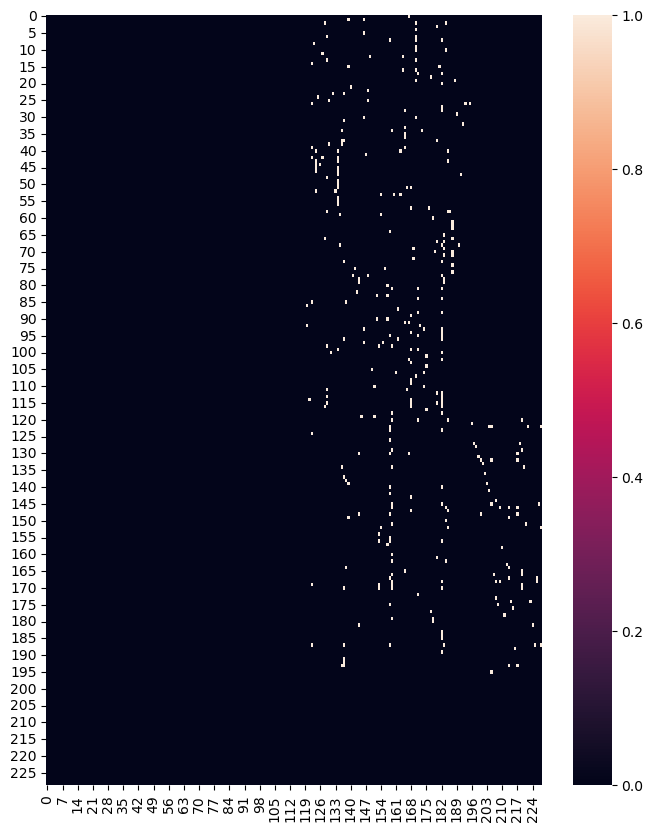

In [19]:
#Plot the adjacency matrix
sns.heatmap(am)
plt.rcParams["figure.figsize"] = (16,16)

In [20]:
#Adjacency as dataframe
df = pd.DataFrame(am, index=range(1, 230), columns=range(1, 230))

pd.set_option('display.max_columns', 30)  
pd.set_option('display.max_rows', 30)  

display(df)

1    2    3    4    5    6    7    8    9    10   11   12   13   14   \
1      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
5      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
225    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
226    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
227    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
228    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
229    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

     15   ...  215  216  217  218  219  220  221  222  223  224  225  226  \
1      0  ...    0    0    0    0    0    0    0    0    0    0    0    0   
2      0  ...    0    0    0    0    0    0    0    0    0    0    0    0   
3      0  ...    0    0    0    0    0    0    0    0    0    0    0    0   
4      0  ...    0    0    0    0    0    0    0    0    0    0    0    0   
5      0  ...    0    0    0    0    0    0    0    0    0    0    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
225    0  ...    0    0    0    0    0    0    0    0    0    0    0    0   
226    0  ...    0    0    0    0    0    0    0    0    0    0    0    0   
227    0  ...    0    0    0    0    0    0    0    0    0    0    0    0   
228    0  ...    0    0    0    0    0    0    0    0    0    0    0    0   
229    0  ...    0    0    0    0    0    0    0    0    0    0    0    0   

     227  228  229  
1      0    0    0  
2      0    0    0  
3      0    0    0  
4      0    0    0  
5      0    0    0  
..   ...  ...  ...  
225    0    0    0  
226    0    0    0  
227    0    0    0  
228    0    0    0  
229    0    0    0  

[229 rows x 229 columns]

## Length of supply chain(path length)


In this block we want to find the length of the supply chain. We only want the path length from top-level suppliers to the retailers, so intermediate pairs will need to be filtered out.  

In [21]:
#find the pathlength between 2 nodes
def pathlen(G, sourcenode, targetnode):
    try:
        pathlength = nx.shortest_path_length(G, source=sourcenode, target=targetnode)
        return pathlength
    #return no path if no path is found
    except nx.NetworkXNoPath:
        return 'no path found'

In [22]:
pathlen(G, 41, 211)

4

In [23]:
#find the shortest path and shortest path length in the whole network 
def shortestpath(G):
    pathlist = [[0, 0]] #initialize a list to store the paths
    pathdict = dict(nx.all_pairs_shortest_path(G)) #shortest path for all pair of nodes in the network
    for source, shortestpaths in pathdict.items():
        for target, path in shortestpaths.items():
            if source != target:
                if (G.in_degree(path[0]) == 0) and (G.out_degree(path[-1])== 0): #filter out intermediate pairs
                    if len(path) <= len(pathlist[-1]):
                        pathlist.append(path)
    pathlist = pathlist[1:]
    return pathlist, len(pathlist[0])-1 #return all shortest paths in the supply chain and its length

In [24]:
spaths, spathlen = shortestpath(G)
spaths

[[8, 183],
 [18, 183],
 [18, 172],
 [21, 183],
 [25, 126],
 [28, 183],
 [29, 183],
 [35, 160],
 [59, 187],
 [60, 136],
 [69, 136],
 [69, 183],
 [69, 191],
 [74, 183],
 [78, 183],
 [82, 183],
 [82, 172],
 [82, 160],
 [85, 183],
 [85, 172],
 [89, 183],
 [89, 172],
 [94, 183],
 [95, 183],
 [96, 183],
 [96, 172],
 [97, 183],
 [99, 160],
 [99, 154],
 [100, 172],
 [101, 183],
 [103, 183],
 [113, 183],
 [114, 183],
 [115, 183],
 [116, 183],
 [117, 183],
 [119, 183],
 [119, 160]]

In [25]:
#find longest path and path length in graph
def longestpath(G):
    #to use the networkx longest path function we need a acyclic directed graph, so we drop the self loop edges first
    GL = G.copy()
    GL.remove_edges_from(list(nx.selfloop_edges(G)))
    return nx.dag_longest_path(GL), nx.dag_longest_path_length(GL)

In [26]:
longestpath(G)

([41, 125, 123, 159, 211], 4)

In [27]:
#find the average path length of the graph
def avglength(G):
    pathlist = []
    pathdict = dict(nx.all_pairs_shortest_path(G))
    for source, shortestpaths in pathdict.items():
        for target, path in shortestpaths.items():
            if source != target:
                if (G.in_degree(path[0]) == 0) and (G.out_degree(path[-1])== 0):
                    pathlist.append(path)
    avg = sum(len(i)-1 for i in pathlist)/len(pathlist)
    return avg

In [28]:
avglength(G)

2.2484342379958244

## Degree distribution ##
This block plot the degree distribution to observe the possible underlying distributions

Since the graph is directed, in-degree and out-degree need to be considered seperately.

In [29]:
#in-degree distribution
degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
in_deg, in_cnt = zip(*degreeCount.items())

#normalizing the degree distribution and put into numpy arrays
in_cntnorm = np.array(in_cnt)/sum(in_cnt)
in_deg = np.array(in_deg)

In [30]:
in_deg, in_cntnorm

(array([33, 17, 15, 13, 11,  8,  7,  6,  5,  4,  3,  2,  1,  0]),
 array([0.00436681, 0.00436681, 0.00436681, 0.00873362, 0.00873362,
        0.01746725, 0.00873362, 0.01746725, 0.03056769, 0.01746725,
        0.03930131, 0.069869  , 0.24017467, 0.52838428]))

In [31]:
#out-degree distribution
degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
out_deg, out_cnt = zip(*degreeCount.items())

#normalizing the degree distribution
out_cntnorm = np.array(out_cnt)/sum(out_cnt)
out_deg = np.array(out_deg)

In [32]:
out_deg, out_cntnorm

(array([6, 5, 4, 3, 2, 1, 0]),
 array([0.00436681, 0.01746725, 0.0349345 , 0.11353712, 0.27947598,
        0.36681223, 0.18340611]))

Text(0.5, 1.0, 'Degree distribution of the supply chain network')

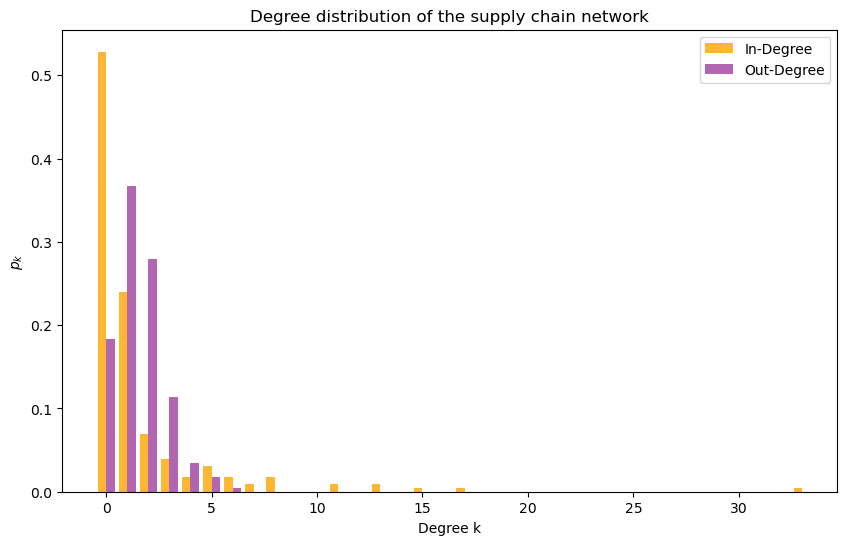

In [33]:
plt.rcParams["figure.figsize"] = (10,6)
fig, ax = plt.subplots()
width = 0.4 #set the bar width

# Calculate the positions for the bars to share x axis without overlapping
in_positions = [x - width/2 for x in in_deg]
out_positions = [x + width/2 for x in out_deg]


plt.bar(in_positions, in_cntnorm, width=width, color='orange', label='In-Degree', alpha = 0.8 )
plt.bar(out_positions, out_cntnorm, width=width, color='purple', label='Out-Degree', alpha = 0.6)


plt.ylabel("$p_k$")
plt.xlabel("Degree k")
plt.legend()
plt.title("Degree distribution of the supply chain network")




### Model Fitting 
To see if the degree distribution follows a specific distribution, we'll fit it against the power law distribution, exponential decay model, and the log-normal distribution. Then we'll perform the chi-square test to determine which model better represents the underlying distribution of the degree distribution.

To prevent the 0 degree results in undefined value for power law and lognormal function, the degree is shifted by one for all

In [34]:
in_deg = in_deg +1
out_deg = out_deg +1
in_deg, out_deg

(array([34, 18, 16, 14, 12,  9,  8,  7,  6,  5,  4,  3,  2,  1]),
 array([7, 6, 5, 4, 3, 2, 1]))

In [35]:
#function to fit a model and return optimized parameters
def fitting(model, deg, cntnorm):
    param, covariance = scipy.optimize.curve_fit(model, deg, cntnorm)
    a, b = param
    return a, b

In [36]:
# Define the power law model function
def power_law(x, a, b): #a, b are parameters to be estimated 
    return a * x**(-b)

In [37]:
# Define the exponential distribution function
def exp(x, a, b):
    return a * np.exp(-b * x)

In [38]:
# Define the lognormal model function
def lognormal(x, mu, sigma): #mu, sigma are parameters to be estimated 
    return (1/(x*sigma*np.sqrt(2*np.pi)))* (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)))

In [39]:
#normalize the fitted curve
def norm(y):
    yn = 1/sum(y)*y
    return yn

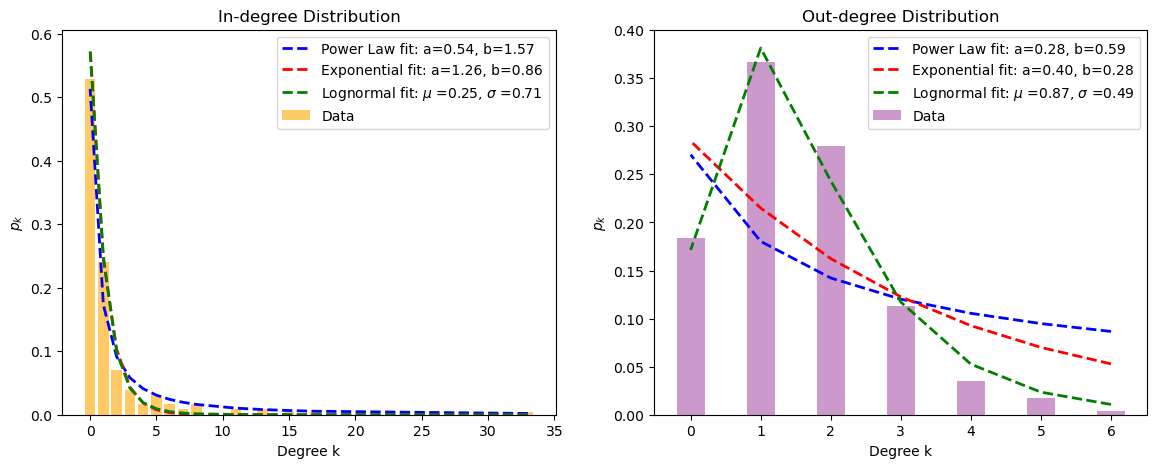

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot the data and fitted curves for in-degree distribution
axes[0].bar(in_deg-1, in_cntnorm, width=0.8, color='orange', label='Data',  alpha = 0.6)
a1, b1 = fitting(power_law, in_deg, in_cntnorm)
y1 = norm(power_law(in_deg, a1, b1))
a2, b2 = fitting(exp, in_deg, in_cntnorm)
y2 = norm(exp(in_deg, a2, b2))
mu, sigma = fitting(lognormal, in_deg, in_cntnorm)
y3 = norm(lognormal(in_deg, mu, sigma))
#degree shifted back by 1
axes[0].plot(in_deg-1, y1, 'b', lw=2, label=f'Power Law fit: a={a1:.2f}, b={b1:.2f}', linestyle='--')
axes[0].plot(in_deg-1, y2, 'r', lw=2, label=f'Exponential fit: a={a2:.2f}, b={b2:.2f}', linestyle='--')
axes[0].plot(in_deg-1, y3, 'g', lw=2, label=f'Lognormal fit: $\mu$ ={mu:.2f}, $\sigma$ ={sigma:.2f}', linestyle='--')

axes[0].set_title('In-degree Distribution')
axes[0].set_xlabel('Degree k')
axes[0].set_ylabel("$p_k$")
axes[0].legend()

# Plot the data and fitted curves for out-degree distribution
axes[1].bar(out_deg-1, out_cntnorm, width=0.4, color='purple', label='Data', alpha = 0.4)
a1, b1 = fitting(power_law, out_deg, out_cntnorm)
y4 = norm(power_law(out_deg, a1, b1))
a2, b2 = fitting(exp, out_deg, out_cntnorm)
y5 = norm(exp(out_deg, a2, b2))
mu, sigma = fitting(lognormal, out_deg, out_cntnorm)
y6 = norm(lognormal(out_deg, mu, sigma))
axes[1].plot(out_deg-1, y4, 'b', lw=2, label=f'Power Law fit: a={a1:.2f}, b={b1:.2f}', linestyle='--')
axes[1].plot(out_deg-1, y5, 'r', lw=2, label=f'Exponential fit: a={a2:.2f}, b={b2:.2f}', linestyle='--')
axes[1].plot(out_deg-1, y6, 'g', lw=2, label=f'Lognormal fit: $\mu$ ={mu:.2f}, $\sigma$ ={sigma:.2f}', linestyle='--')

axes[1].set_title('Out-degree Distribution')
axes[1].set_xlabel('Degree k')
axes[1].set_ylabel("$p_k$")
axes[1].legend()


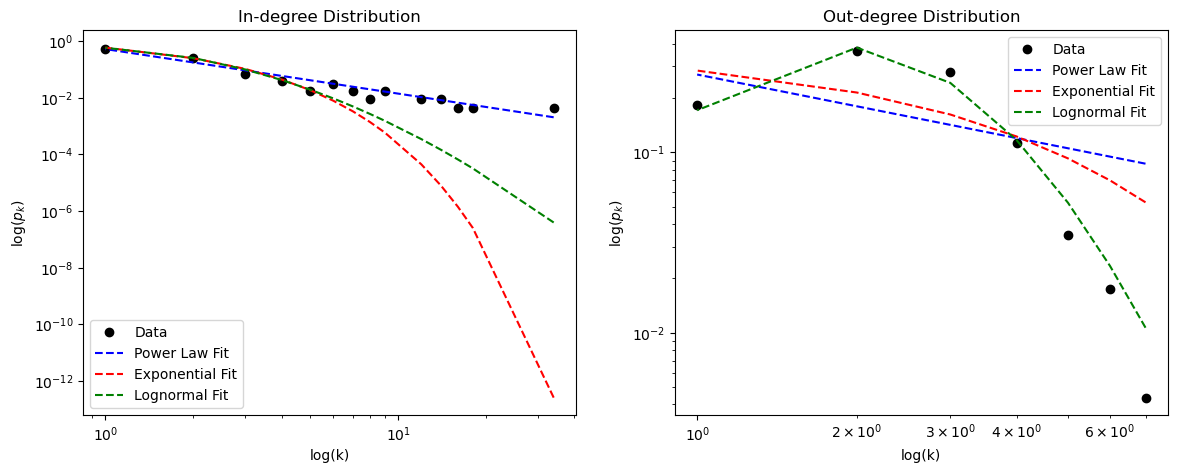

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot in log scale
axes[0].loglog(in_deg, in_cntnorm, 'o', color='black', label='Data')

axes[0].loglog(in_deg,y1, 'b', label = 'Power Law Fit', linestyle='--')
axes[0].loglog(in_deg,y2, 'r', label = 'Exponential Fit', linestyle='--')
axes[0].loglog(in_deg,y3, 'g', label = 'Lognormal Fit', linestyle='--')

axes[0].set_title('In-degree Distribution')
axes[0].set_xlabel('log(k)')
axes[0].set_ylabel("log($p_k$)")
axes[0].legend()


axes[1].loglog(out_deg, out_cntnorm, 'o', color='black', label='Data')

axes[1].loglog(out_deg,y4, 'b', label = 'Power Law Fit', linestyle='--')
axes[1].loglog(out_deg,y5, 'r', label = 'Exponential Fit', linestyle='--')
axes[1].loglog(out_deg,y6, 'g', label = 'Lognormal Fit', linestyle='--')

axes[1].set_title('Out-degree Distribution')
axes[1].set_xlabel('log(k)')
axes[1].set_ylabel("log($p_k$)")
axes[1].legend()


### Chi-Square Test
We perform the chi-square test to exam the goodness of fit of the 3 models. 

In [42]:
#degree of freedom used for chi-squre test(data points-1)
in_dof = len(in_deg)-1
out_dof = len(out_deg)-1
in_dof, out_dof

(13, 6)

In [43]:
#calculate chisq and p values
def chisq(cnt, y): 
    chisq, pvalue = scipy.stats.chisquare(f_obs = cnt, f_exp = np.sum(cnt) * y) #figured out, suppose to use cnt not cntnorm here
    return chisq, pvalue

In [44]:
#For in Degree distrubution
pl_chisq, pl_pvalue = chisq(in_cnt, y1)
exp_chisq, exp_pvalue = chisq(in_cnt, y2)
logn_chisq, logn_pvalue = chisq(in_cnt, y3)

in_data = {
    'Model': ['Power Law', 'Exponential', 'Lognormal'],
    'Chi-Square': [pl_chisq, exp_chisq, logn_chisq],
    'P-Value': [pl_pvalue, exp_pvalue, logn_pvalue]
}

# Creating a DataFrame
indf = pd.DataFrame(in_data)
indf

Model    Chi-Square   P-Value
0    Power Law  1.450855e+01  0.339028
1  Exponential  1.673879e+10  0.000000
2    Lognormal  1.155986e+04  0.000000

In [45]:
#For out Degree distrubution
pl_chisq, pl_pvalue = chisq(out_cnt, y4)
exp_chisq, exp_pvalue = chisq(out_cnt, y5)
logn_chisq, logn_pvalue = chisq(out_cnt, y6)

out_data = {
    'Model': ['Power Law', 'Exponential', 'Lognormal'],
    'Chi-Square': [pl_chisq, exp_chisq, logn_chisq],
    'P-Value': [pl_pvalue, exp_pvalue, logn_pvalue]
}

# Creating a DataFrame
outdf = pd.DataFrame(out_data)
outdf

Model  Chi-Square       P-Value
0    Power Law  124.172944  2.163413e-24
1  Exponential   79.768058  3.989546e-15
2    Lognormal    4.147366  6.567415e-01

## Centrality
(This part is not included in the report, just testing out)

The degree centrality for a node is the fraction of nodes it is connected to. 

In [46]:
def deg_centrality(G):
    return dict(sorted(nx.degree_centrality(G).items(), key=lambda item: item[1], reverse = True))  
#deg_centrality(G)

The closeness centrality for a node measures how quickly a node can reach all other nodes in the network.

In [47]:
def clo_centrality(G):
    return dict(sorted(nx.closeness_centrality(G).items(), key=lambda item: item[1], reverse = True))  
#clo_centrality(G)

The betweenness centrality for a node measures how often a node acts as a bridge along the shortest paths between other nodes

In [48]:
def btw_centrality(G):
    return dict(sorted(nx.betweenness_centrality(G).items(), key=lambda item: item[1], reverse = True))  
#btw_centrality(G)

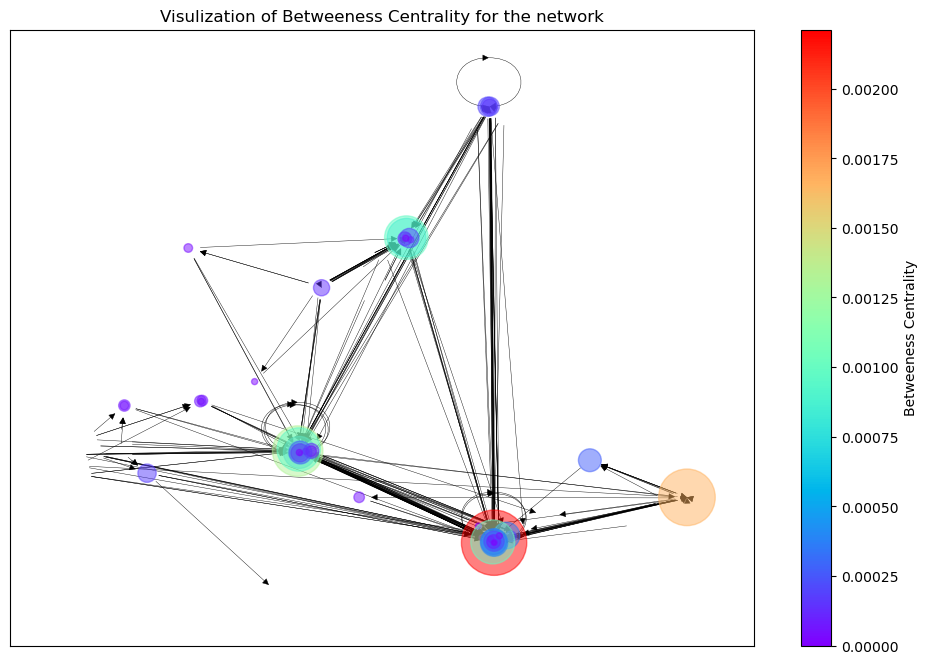

In [49]:
#plot graph G with node size and color based on betweenness_centrality values
plt.rcParams["figure.figsize"] = (12,8)

colors = [nx.betweenness_centrality(G)[node] for node in G.nodes]
size = [1000000*(nx.betweenness_centrality(G)[node]) for node in G.nodes]
nx.draw_networkx_nodes(G, positions, node_color=colors,cmap=plt.cm.rainbow, node_size=size, alpha = 0.5, vmin=min(colors), vmax=max(colors))
nx.draw_networkx_edges(G, positions, width=0.3)
sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, norm=plt.Normalize(vmin=min(colors), vmax=max(colors)))

plt.title('Visulization of Betweeness Centrality for the network')
plt.colorbar(sm, label='Betweeness Centrality')
plt.show()

## Clustering Coefficient 
The clustering coefficient describe the degree to which the neighbors of a specific nodes links to each other, it measures the network's local link density. We'll use the networkx built in function to calculate the clustering coefficient for each node in the graph and the average cluster coefficient for the whole graph.

In [50]:
#calculate the clustering coefficient of a node
def clustering(G, node):
    return nx.clustering(G)[node]

In [51]:
clustering(G, 116)

0.08333333333333333

In [52]:
#list all nodes in graph with CC>0
def listcc(G):
    return {key: value for key, value in (nx.clustering(G)).items() if value > 0}
listcc(G)

{8: 0.16666666666666666,
 72: 0.5,
 95: 0.5,
 99: 0.16666666666666666,
 115: 0.16666666666666666,
 116: 0.08333333333333333,
 117: 0.16666666666666666,
 123: 0.01282051282051282,
 130: 0.011111111111111112,
 131: 0.03333333333333333,
 159: 0.008333333333333333,
 160: 0.003676470588235294,
 168: 0.023809523809523808,
 169: 0.013071895424836602,
 171: 0.004166666666666667,
 183: 0.004734848484848485,
 184: 0.017857142857142856,
 188: 0.016483516483516484,
 229: 0.16666666666666666}

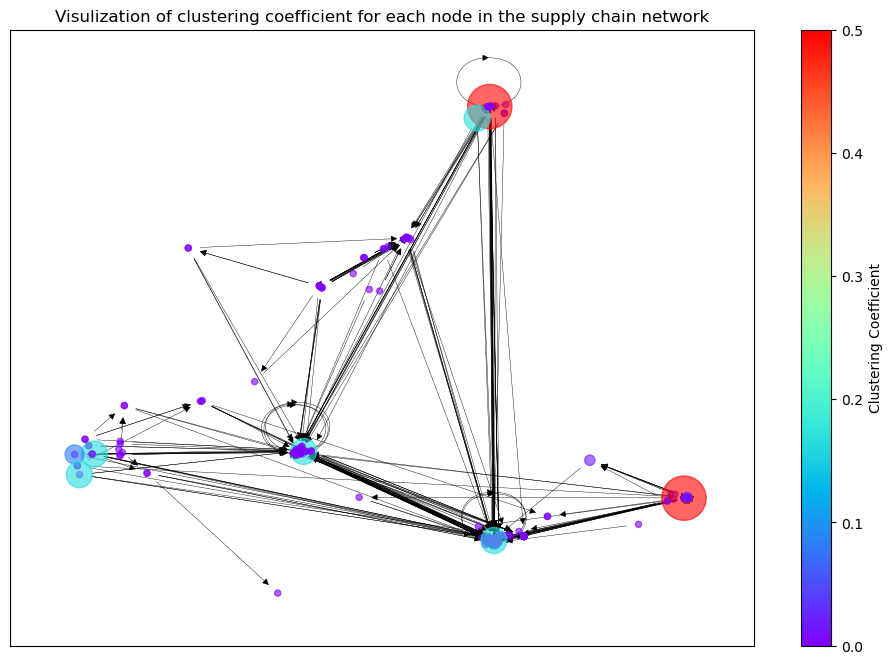

In [53]:
#visualize the clustering coefficient on the network
plt.rcParams["figure.figsize"] = (12,8)

colors = [nx.clustering(G)[node] for node in G.nodes]
size = [2000*(nx.clustering(G)[node]+0.01) for node in G.nodes] #enlarge the node with cc>0 so it can be observed
nx.draw_networkx_nodes(G, positions, node_color=colors,cmap=plt.cm.rainbow, node_size=size, alpha = 0.6, vmin=0, vmax=max(colors))
nx.draw_networkx_edges(G, positions, width=0.3)
sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, norm=plt.Normalize(vmin=0, vmax=max(colors)))

plt.title('Visulization of clustering coefficient for each node in the supply chain network')
plt.colorbar(sm, label='Clustering Coefficient')

Calculate the average clustering coefficient of the whole graph:

In [54]:
def avgcc(G):
    return nx.average_clustering(G)
avgcc(G)

0.009022117998164747

Calculate the transitivity(global clustering coefficent) of a graph, it measures the fraction of all possible triangles in G.

In [55]:
def globalcc(G):
    return nx.transitivity(G)
globalcc(G)

0.0205761316872428

## Pagerank
Pagerank calculates a rank for each node in the network based on the structure of incoming links. It is a measure of how important or influential a node is within the network. We'll use the networkx built-in nx.pagerank() function to calculate rankings for the nodes in the supply chain. 

In [56]:
#Calculate pagerank for graph G, sorted high to low
def pagerank(G):
    return dict(sorted(nx.pagerank(G).items(), key=lambda item: item[1], reverse = True))  
pagerank(G) #display(node: score)

{138: 0.09706866560237025,
 183: 0.04865533563278765,
 158: 0.03128302644845417,
 160: 0.025677483590176135,
 139: 0.025618646944638782,
 159: 0.02359539806236144,
 211: 0.021802845022381858,
 178: 0.021436585516302984,
 220: 0.015680590943705032,
 169: 0.01561599362678752,
 166: 0.01463500431846726,
 135: 0.013725774762127265,
 123: 0.01288959217887683,
 171: 0.011625824155197854,
 188: 0.011378771142617925,
 208: 0.011330438976394545,
 212: 0.010938455350655176,
 179: 0.010815710829604037,
 154: 0.009071322499397497,
 184: 0.008544027997680396,
 203: 0.008407125225728434,
 172: 0.00840502410610088,
 185: 0.008313235308376393,
 137: 0.007838165589016292,
 181: 0.007685416377355888,
 130: 0.007549449447628999,
 140: 0.007448194947494151,
 214: 0.007185760037303252,
 206: 0.0070698530533007614,
 229: 0.006461623983435234,
 186: 0.006231016110602777,
 176: 0.006190657878439382,
 147: 0.005943604865859451,
 227: 0.005927285657601647,
 145: 0.0059159796331594025,
 205: 0.005837624952253733

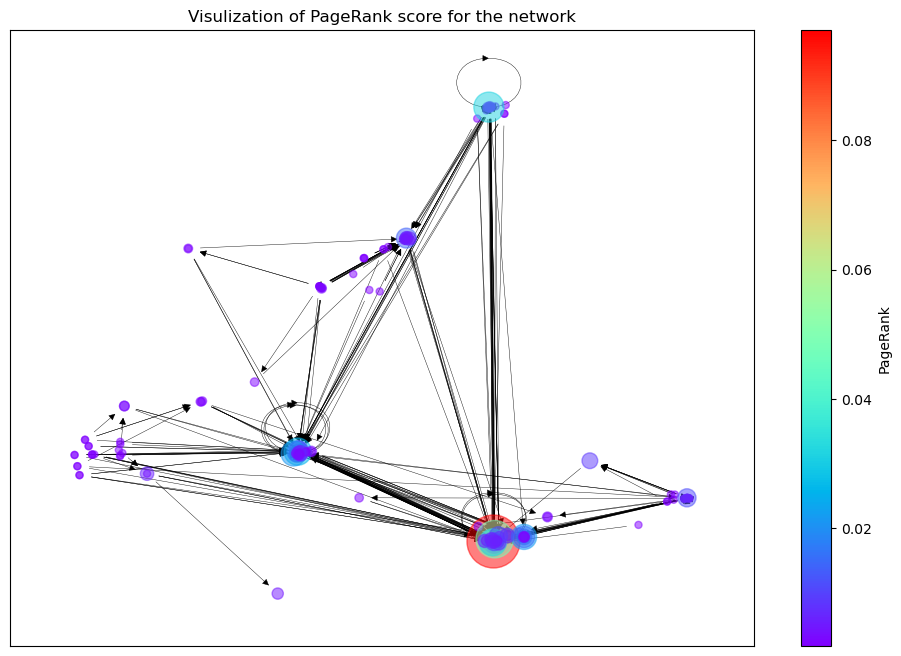

In [57]:
#plot graph G with node size and color based on page rank
plt.rcParams["figure.figsize"] = (12, 8)
colors = [nx.pagerank(G)[node] for node in G.nodes]
size = [15000*(nx.pagerank(G)[node]) for node in G.nodes]
nx.draw_networkx_nodes(G, positions, node_color=colors,cmap=plt.cm.rainbow, node_size=size, alpha = 0.5, vmin=min(colors), vmax=max(colors))
nx.draw_networkx_edges(G, positions, width=0.3)
sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, norm=plt.Normalize(vmin=min(colors), vmax=max(colors)))


plt.title('Visulization of PageRank score for the network')
plt.colorbar(sm, label='PageRank')
plt.show()

In [58]:
#making a pagerank score probability plot 
numbins = 80
minp = min(pagerank(G).values())
maxp = max(pagerank(G).values())

width = (maxp - minp) / numbins
bins = [minp + i * width for i in range(numbins)]
bins.append(maxp)
#Initialize the counts
counts = {i: 0 for i in range(numbins+1)}
for node, value in pagerank(G).items():
        ind = int((value - minp) / width)
        counts[ind] += 1

Text(0.5, 0, 'PageRank Score')

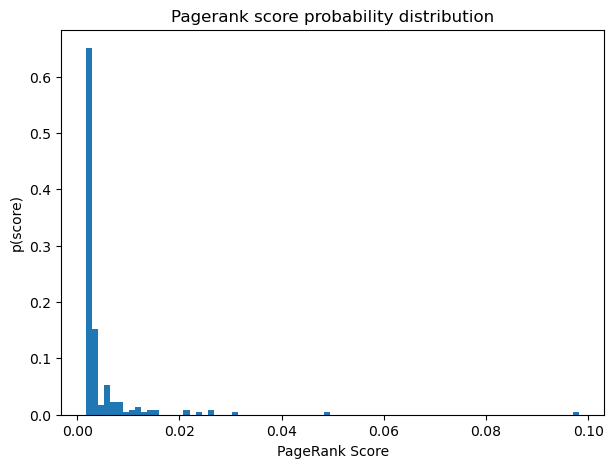

In [59]:
plt.rcParams["figure.figsize"] = (7, 5)
plt.bar(bins[:], np.array(list(counts.values()))/229.0, width=width, align='edge')
plt.title('Pagerank score probability distribution')
plt.ylabel('p(score)')
plt.xlabel('PageRank Score')

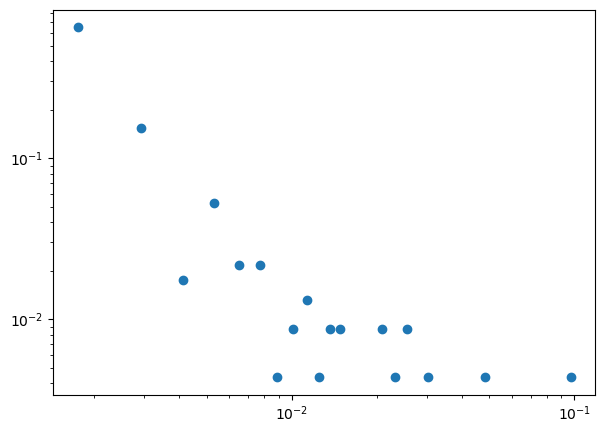

In [60]:
#inspect the loglog plot
plt.rcParams["figure.figsize"] = (7, 5)
plt.loglog(bins[:], np.array(list(counts.values()))/229.0, 'o')

## Network by Region
Pharmacies/OTCs are separated roughly into six regions, a Graph object is created for each region. 

First create some functions to reuse for every region, reduce duplications. 

In [61]:
#function to extract suppliers information from dataframe
def extractsupp(df):
    slist = df[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']].stack().unique().astype(int)
    return pharmacy_data[pharmacy_data['Codes'].isin(slist)]

In [62]:
#Concatenate dataframes extracted
def concatdf(df):
    sdf = extractsupp(df)
    ssdf = extractsupp(sdf)
    sssdf = extractsupp(ssdf) #extra layer to ensure no node is missed
    fdf = pd.concat([df, sdf, ssdf, sssdf], ignore_index=True)
    fdf = fdf.drop_duplicates() #check for duplicate nodes in the df
    return fdf 

In [63]:
#function to create a graph from a specified dataframe
def makegraph(df):
    xxxx=df['Infor']
    G=nx.DiGraph()
    codex = np.array(df['Codes']).astype(int)
    s1x=np.array(df['S1']).astype(int)
    s2x=np.array(df['S2']).astype(int)
    s3x=np.array(df['S3']).astype(int)
    s4x=np.array(df['S4']).astype(int)
    s5x=np.array(df['S5']).astype(int)
    s6x=np.array(df['S6']).astype(int)
    s7x=np.array(df['S7']).astype(int)
    s8x=np.array(df['S8']).astype(int)
    s9x=np.array(df['S9']).astype(int)

    longlat=np.column_stack((df['longitude'],df['latitude']))
    G.add_nodes_from(codex)
    positions = dict(zip(G.nodes, longlat))
    
    xlist = [s1x, s2x, s3x, s4x, s5x, s6x, s7x, s8x, s9x]
    for nodes in range(codex.size): 
        for i in xlist:
            x = i[nodes]
            if x!=0 : 
                G.add_edge(codex[nodes],x)
    return G, xxxx, codex, positions 

In [64]:
#function to draw graph
def drawgraph(G):
    plt.rcParams["figure.figsize"] = (5,8)
    
    nx.draw_networkx_nodes(G, positions, nodelist=codex[xxxx=='OTC'], node_color="red",node_size=40, label='OTC')
    nx.draw_networkx_nodes(G, positions, nodelist=codex[xxxx=='Pharmacy'], node_color="blue",node_size=40, label='Pharmacy')
    nx.draw_networkx_nodes(G, positions, nodelist=codex[xxxx=='Supplier'], node_color="green",node_size=40, label='Supplier')

    nx.draw_networkx_edges(G, positions, width = 0.4)

    plt.legend()
    plt.show()

In [65]:
#function to draw map(icon marker)
def drawmap(df, G):
    m = folium.Map(location=[7.9465, -1.0232], zoom_start=7)    
    GeoJson(text,
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'black',  # Border color
        'weight': 1.8
        # Border width
    }).add_to(m)
    # Add markers for each OTC location
    for index, row in (df[df['Infor'] == 'Supplier']).iterrows():
        folium.Marker(location=[row['latitude'], row['longitude']], 
                           icon=folium.Icon(color='green', icon = 'truck-field', prefix='fa'),
                           popup=row['A7_Organisation_Name']).add_to(m)
    
    # Add markers for each supplier location
    for index, row in (df[df['Infor'] == 'Pharmacy']).iterrows():
        folium.Marker(location=[row['latitude'], row['longitude']], 
                           icon=folium.Icon(color='blue', icon = 'prescription-bottle-medical', prefix='fa'),
                           popup=row['A7_Organisation_Name']).add_to(m)
    
    # Add markers for each pharmacy location
    for index, row in (df[df['Infor'] == 'OTC']).iterrows():
        folium.Marker(location=[row['latitude'], row['longitude']], 
                           icon=folium.Icon(color='red', icon = 'prescription-bottle-medical',  prefix='fa'),
                           popup=row['A7_Organisation_Name']).add_to(m)
        
    #Add polylines between the locations
    edges = list(G.edges()) #list of edges
    latlong=np.column_stack((df['latitude'], df['longitude']))
    latlong = dict(zip(G.nodes, latlong))
    for edge in edges:
        folium.PolyLine(locations=[latlong[edge[0]], latlong[edge[1]]], color='black', weight=0.8).add_to(m)
    #FloatImage(image_file, bottom=1, left=1).add_to(m)
    minimap = MiniMap(position='topright', width=150, height=150)
    m.add_child(minimap)
    # Display the map
    return m

In [66]:
#function to draw map(circle marker)
def drawmap_circ(df, G):
    m = folium.Map(location=[7.9465, -1.0232], zoom_start=7)
    # Add markers for each OTC location
    for index, row in (df[df['Infor'] == 'OTC']).iterrows():
        folium.CircleMarker(location=[row['latitude'], row['longitude']], 
                        color = 'red', radius =4, fill = True, fill_opacity = 0.6, 
                        popup=row['A7_Organisation_Name']).add_to(m)
    
    # Add markers for each pharmacy location
    for index, row in (df[df['Infor'] == 'Pharmacy']).iterrows():
        folium.CircleMarker(location=[row['latitude'], row['longitude']], 
                           color = 'blue', radius =4, fill = True, fill_opacity = 0.6,
                           popup=row['A7_Organisation_Name']).add_to(m)
    
    # Add markers for each supplier location
    for index, row in (df[df['Infor'] == 'Supplier']).iterrows():
        folium.CircleMarker(location=[row['latitude'], row['longitude']], 
                           color = 'green', radius =4, fill = True, fill_opacity = 0.6,
                           popup=row['A7_Organisation_Name']).add_to(m)
        
    #Add polylines between the locations
    edges = list(G.edges()) 
    latlong=np.column_stack((df['latitude'], df['longitude']))
    latlong = dict(zip(G.nodes, latlong))
    for edge in edges:
        folium.PolyLine(locations=[latlong[edge[0]], latlong[edge[1]]], color='black', weight=0.5).add_to(m)
    FloatImage(image_file, bottom=1, left=1).add_to(m)
    # Display the map
    return m

### Upper East Region
Select the pharmacies/OTCs with latitude higher than 10.5

In [67]:
#Extract the retailers in upper east region
uppereastdf = pharmacy_data[(pharmacy_data['latitude']>10) & (pharmacy_data['Infor'].isin(['Pharmacy', 'OTC']))]
#Suppliers of the upper east region retailers
uppereastdf = concatdf(uppereastdf)
uppereastdf

OID_   DI     Infor   latitude  longitude  Codes  \
0    82.0  F55       OTC  11.062912  -0.230438     55   
1    56.0  F81       OTC  11.046448  -0.248158     81   
2    36.0  F82       OTC  11.061507  -0.240374     82   
3   112.0  F83       OTC  11.053119  -0.243561     83   
4    55.0  F84       OTC  11.054141  -0.264993     84   
..    ...  ...       ...        ...        ...    ...   
65    0.0    0  Supplier   5.626706   0.005751    223   
66    0.0    0  Supplier   5.626706   0.005751    224   
67    0.0    0  Supplier   5.564263  -0.220263    227   
68    0.0    0  Supplier   5.575025  -0.211214    229   
76    0.0    0  Supplier   5.626706   0.005751    203   

                    A7_Organisation_Name     S1   S2   S3     S4   S5   S6  \
0                                  BUCAS  135.0  0.0  0.0  135.0  0.0  0.0   
1                   Alice Apasiba Azongo  158.0  0.0  0.0  158.0  0.0  0.0   
2         Hassan YAHAYA LICENSED CHEMIST  183.0  0.0  0.0  172.0  0.0  0.0   
3                   IBRAHIM SALAMATU OTC  144.0  0.0  0.0    0.0  0.0  0.0   
4                      Atuut Abuguri OTC  153.0  0.0  0.0  158.0  0.0  0.0   
..                                   ...    ...  ...  ...    ...  ...  ...   
65        Bliss GV Pharma limited_Mumbai    0.0  0.0  0.0    0.0  0.0  0.0   
66                    Attar Global_India    0.0  0.0  0.0    0.0  0.0  0.0   
67                Eskay Therapeutics Ltd    0.0  0.0  0.0    0.0  0.0  0.0   
68  Amponsah Effah Pharmaceuticals_Accra    0.0  0.0  0.0    0.0  0.0  0.0   
76   Mangalam Drugs and Organics Limited    0.0  0.0  0.0    0.0  0.0  0.0   

       S7   S8   S9  
0     0.0  0.0  0.0  
1   158.0  0.0  0.0  
2   160.0  0.0  0.0  
3     0.0  0.0  0.0  
4   158.0  0.0  0.0  
..    ...  ...  ...  
65    0.0  0.0  0.0  
66    0.0  0.0  0.0  
67    0.0  0.0  0.0  
68    0.0  0.0  0.0  
76    0.0  0.0  0.0  

[61 rows x 16 columns]

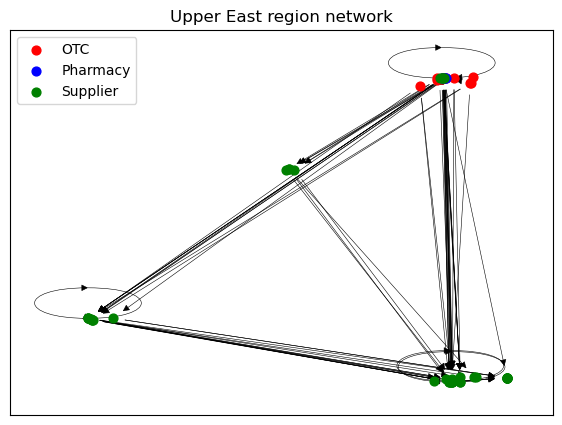

In [68]:
#Create the network graph G1
G1, xxxx, codex, positions = makegraph(uppereastdf)
#Draw the graph
plt.title('Upper East region network')
drawgraph(G1)

In [69]:
#Display map
drawmap(uppereastdf, G1)

### Tamale Region
Select the pharmacies/OTCs with latitude between 8.5 and 10.0, longitude larger than -2.4.

In [70]:
tbdf = pharmacy_data[(pharmacy_data['latitude']>8.5) & (pharmacy_data['latitude']<10)&(pharmacy_data['longitude']>-2.4) &(pharmacy_data['Infor'].isin(['Pharmacy', 'OTC']))]
#Suppliers of the Tamale-Buipe region retailers
tbdf = concatdf(tbdf)
tbdf

OID_   DI     Infor  latitude  longitude  Codes  \
0    13.0  F41       OTC  8.789498  -1.466447     41   
1    62.0  F42       OTC  8.776213  -1.455993     42   
2   108.0  F43       OTC  9.262246  -1.008211     43   
3    83.0  F44       OTC  8.772583  -1.454515     44   
4   109.0  F45       OTC  9.290427  -0.975414     45   
..    ...  ...       ...       ...        ...    ...   
59    0.0    0  Supplier  5.626706   0.005751    223   
60    0.0    0  Supplier  5.564263  -0.220263    227   
61    0.0    0  Supplier  5.575025  -0.211214    229   
66    0.0    0  Supplier  5.626706   0.005751    203   
71    0.0    0  Supplier  5.626706   0.005751    211   

                    A7_Organisation_Name     S1     S2     S3     S4     S5  \
0               Enye Maho)dene chemicals  186.0  125.0  135.0  186.0  125.0   
1                         Hayford Mensah  148.0    0.0    0.0  148.0    0.0   
2                          Shahadu Adams  135.0  128.0  123.0    0.0    0.0   
3                 Abdulai Hardi Nyalabah  186.0    0.0    0.0  135.0    0.0   
4                    Mohammed Adam Abudu  127.0  125.0  125.0    0.0    0.0   
..                                   ...    ...    ...    ...    ...    ...   
59        Bliss GV Pharma limited_Mumbai    0.0    0.0    0.0    0.0    0.0   
60                Eskay Therapeutics Ltd    0.0    0.0    0.0    0.0    0.0   
61  Amponsah Effah Pharmaceuticals_Accra    0.0    0.0    0.0    0.0    0.0   
66   Mangalam Drugs and Organics Limited    0.0    0.0    0.0    0.0    0.0   
71                                  IPCA    0.0    0.0    0.0    0.0    0.0   

       S6     S7     S8     S9  
0   135.0  164.0  125.0  135.0  
1     0.0  148.0    0.0    0.0  
2     0.0    0.0    0.0    0.0  
3     0.0  125.0    0.0    0.0  
4     0.0    0.0    0.0    0.0  
..    ...    ...    ...    ...  
59    0.0    0.0    0.0    0.0  
60    0.0    0.0    0.0    0.0  
61    0.0    0.0    0.0    0.0  
66    0.0    0.0    0.0    0.0  
71    0.0    0.0    0.0    0.0  

[61 rows x 16 columns]

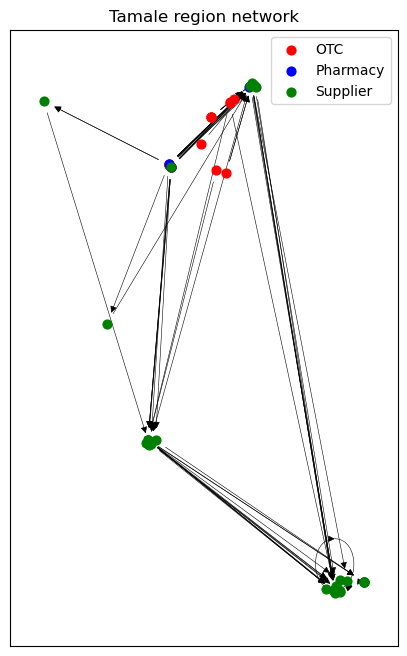

In [71]:
#Create the network graph G2
G2, xxxx, codex, positions = makegraph(tbdf)
#Draw the graph
plt.title('Tamale region network')
drawgraph(G2)

In [72]:
#Display map
drawmap(tbdf, G2)

### Volta Region
Select the pharmacies/OTCs with longitude larger than 0.48.

In [73]:
vrdf = pharmacy_data[(pharmacy_data['longitude']>0.48) &(pharmacy_data['Infor'].isin(['Pharmacy', 'OTC']))]
#Suppliers of the Volta region retailers
vrdf = concatdf(vrdf)

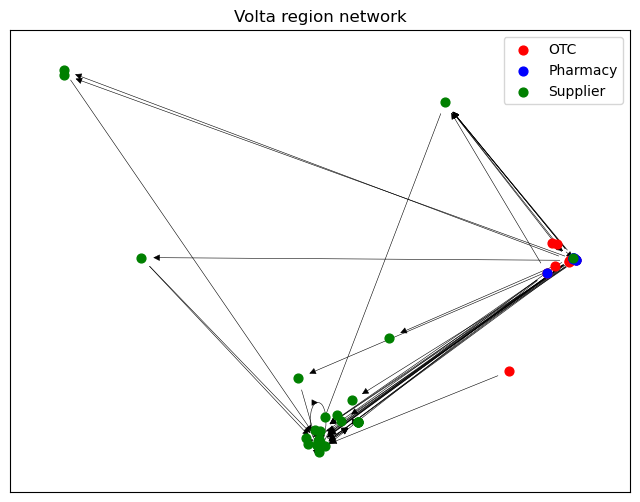

In [74]:
plt.rcParams["figure.figsize"] = (8,6)
#Create the network graph G3
G3, xxxx, codex, positions = makegraph(vrdf)
plt.title('Volta region network')
drawgraph(G3)

In [75]:
#Display map
drawmap(vrdf, G3)

### Accra Region
Select the pharmacies/OTCs with latitude < 6.10, longitude < 0.48.

In [76]:
accradf = pharmacy_data[(pharmacy_data['latitude']<6.1) &(pharmacy_data['longitude']<0.48) &(pharmacy_data['Infor'].isin(['Pharmacy', 'OTC']))]
#Suppliers of the Accra region retailers
accradf = concatdf(accradf)

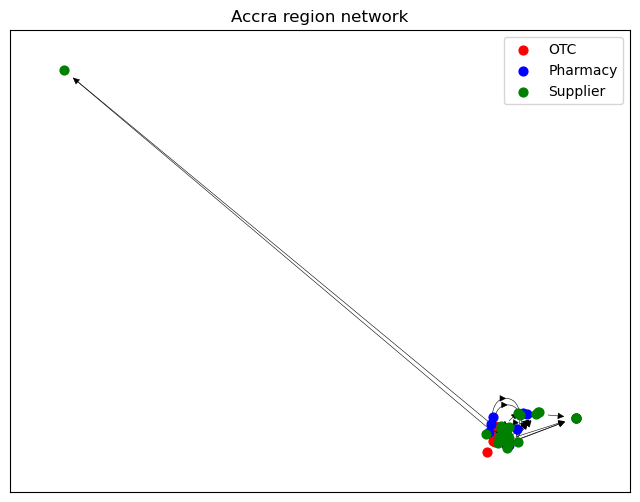

In [77]:
plt.rcParams["figure.figsize"] = (8,6)
#Create the network graph G4
G4, xxxx, codex, positions = makegraph(accradf)
#Draw the graph
plt.title('Accra region network')
drawgraph(G4)

In [78]:
#Display map
drawmap(accradf, G4)

### Kumasi Region
Select the pharmacies/OTCs with 6.66 < latitude < 6.77, -1.66 < longitude < -1.52.

In [79]:
kumasidf = pharmacy_data[(pharmacy_data['latitude']<6.77) &(pharmacy_data['latitude']>6.66)&(pharmacy_data['longitude']<-1.52) &(pharmacy_data['longitude']>-1.66)&(pharmacy_data['Infor'].isin(['Pharmacy', 'OTC']))]
#Suppliers of the Kumasi region retailers
kumasidf = concatdf(kumasidf)
kumasidf

OID_  DI     Infor  latitude  longitude  Codes  \
0   114.0  F1  Pharmacy  6.686896  -1.607081      1   
1    64.0  F2  Pharmacy  6.670298  -1.590986      2   
2    94.0  F3       OTC  6.751693  -1.603975      3   
3    68.0  F4       OTC  6.705169  -1.618656      4   
4    37.0  F5       OTC  6.722547  -1.604707      5   
..    ...  ..       ...       ...        ...    ...   
64    0.0   0  Supplier  5.626706   0.005751    225   
65    0.0   0  Supplier  5.564263  -0.220263    227   
66    0.0   0  Supplier  5.575025  -0.211214    229   
73    0.0   0  Supplier  5.641554  -0.178377    208   
75    0.0   0  Supplier  5.566279  -0.210515    212   

                            A7_Organisation_Name     S1     S2   S3     S4  \
0                                   MEK PHARMACY  168.0    0.0  0.0    0.0   
1                             Kwik save pharmacy  147.0  140.0  0.0  147.0   
2   David Akuoku Over the counter chemical store  185.0  171.0  0.0  129.0   
3                                 Aderic Chemist  181.0    0.0  0.0  181.0   
4                                Rukaya Omar otc  171.0    0.0  0.0  171.0   
..                                           ...    ...    ...  ...    ...   
64                            Mystery Supplier 3    0.0    0.0  0.0    0.0   
65                        Eskay Therapeutics Ltd    0.0    0.0  0.0    0.0   
66          Amponsah Effah Pharmaceuticals_Accra    0.0    0.0  0.0    0.0   
73                                Novartis Ghana    0.0    0.0  0.0    0.0   
75                          Shalina Laboratories    0.0    0.0  0.0    0.0   

     S5   S6     S7   S8   S9  
0   0.0  0.0    0.0  0.0  0.0  
1   0.0  0.0  147.0  0.0  0.0  
2   0.0  0.0    0.0  0.0  0.0  
3   0.0  0.0    0.0  0.0  0.0  
4   0.0  0.0    0.0  0.0  0.0  
..  ...  ...    ...  ...  ...  
64  0.0  0.0    0.0  0.0  0.0  
65  0.0  0.0    0.0  0.0  0.0  
66  0.0  0.0    0.0  0.0  0.0  
73  0.0  0.0    0.0  0.0  0.0  
75  0.0  0.0    0.0  0.0  0.0  

[64 rows x 16 columns]

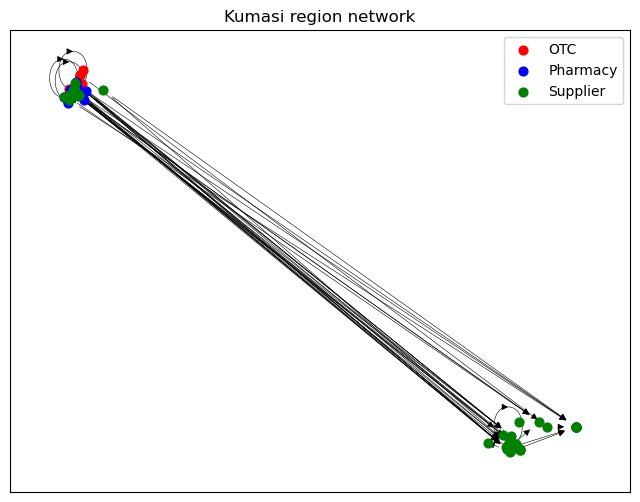

In [80]:
plt.rcParams["figure.figsize"] = (8,6)
#Create the network graph G5
G5, xxxx, codex, positions = makegraph(kumasidf)
#Draw the graph
plt.title('Kumasi region network')
drawgraph(G5)

In [81]:
#Display map
drawmap(kumasidf, G5)

### Western North Region
Select the pharmacies/OTCs with latitude < 7.28, longitude < -2.71.

In [82]:
wndf = pharmacy_data[(pharmacy_data['latitude']<7.28) &(pharmacy_data['longitude']<-2.71) &(pharmacy_data['Infor'].isin(['Pharmacy', 'OTC']))]
#Suppliers of the Western North region retailers
wndf = concatdf(wndf)
wndf

OID_    DI     Infor  latitude  longitude  Codes  \
0   119.0   F64       OTC  6.520290  -3.214840     64   
1    86.0  F101       OTC  6.520290  -3.214840    101   
2   116.0  F102       OTC  6.686925  -2.890278    102   
3    24.0  F103       OTC  6.668493  -3.109823    103   
4    44.0  F104       OTC  6.798953  -2.905178    104   
..    ...   ...       ...       ...        ...    ...   
65    0.0     0  Supplier  5.575025  -0.211214    229   
70    0.0     0  Supplier  5.576033  -0.278855    205   
72    0.0     0  Supplier  5.626706   0.005751    211   
73    0.0     0  Supplier  5.566279  -0.210515    212   
74    0.0     0  Supplier  5.626706   0.005751    223   

                    A7_Organisation_Name     S1   S2   S3     S4   S5   S6  \
0                         Evelyn Nyamadi  188.0  0.0  0.0    0.0  0.0  0.0   
1                      Francis kofi Osei  183.0  0.0  0.0  132.0  0.0  0.0   
2                              Adu Moses  176.0  0.0  0.0    0.0  0.0  0.0   
3                    Joseph Appiah Kobbi  168.0  0.0  0.0  183.0  0.0  0.0   
4                          Peter Tuffour  169.0  0.0  0.0  169.0  0.0  0.0   
..                                   ...    ...  ...  ...    ...  ...  ...   
65  Amponsah Effah Pharmaceuticals_Accra    0.0  0.0  0.0    0.0  0.0  0.0   
70                Unicom Chemist limited    0.0  0.0  0.0    0.0  0.0  0.0   
72                                  IPCA    0.0  0.0  0.0    0.0  0.0  0.0   
73                  Shalina Laboratories    0.0  0.0  0.0    0.0  0.0  0.0   
74        Bliss GV Pharma limited_Mumbai    0.0  0.0  0.0    0.0  0.0  0.0   

       S7   S8   S9  
0     0.0  0.0  0.0  
1   183.0  0.0  0.0  
2     0.0  0.0  0.0  
3     0.0  0.0  0.0  
4     0.0  0.0  0.0  
..    ...  ...  ...  
65    0.0  0.0  0.0  
70    0.0  0.0  0.0  
72    0.0  0.0  0.0  
73    0.0  0.0  0.0  
74    0.0  0.0  0.0  

[67 rows x 16 columns]

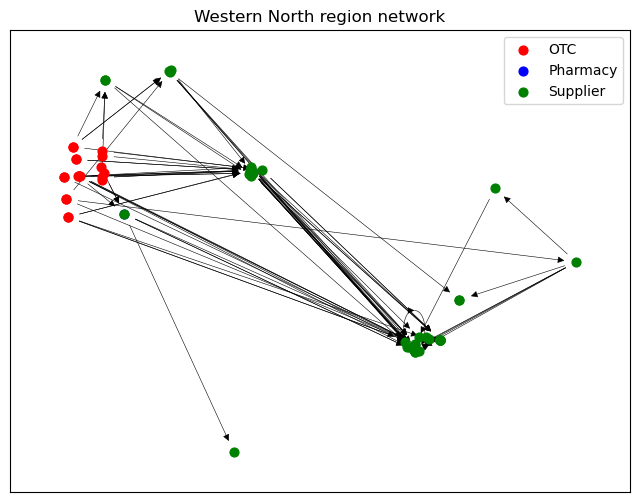

In [83]:
plt.rcParams["figure.figsize"] = (8,6)
#Create the network graph G6
G6, xxxx, codex, positions = makegraph(wndf)
#Draw the graph
plt.title('Western North region network')
drawgraph(G6)

In [84]:
#Display map
drawmap(wndf, G6)

## Network by Medicine Type
Column S1-S3 are used for cheap medicine, S4-S6 for intermediate medicine, and S7-S9 for expensive medicine.

In [85]:
#function to create a graph for each medicine type
def makegraph_med(df, c1, c2, c3):
    xxxx=df['Infor']
    G=nx.DiGraph()
    codex = np.array(df['Codes']).astype(int)
    s1x=np.array(df[c1]).astype(int)
    s2x=np.array(df[c2]).astype(int)
    s3x=np.array(df[c3]).astype(int)

    longlat=np.column_stack((df['longitude'],df['latitude']))
    G.add_nodes_from(codex)
    positions = dict(zip(G.nodes, longlat))
    
    xlist = [s1x, s2x, s3x]
    #  Place edges between supplier and retailers
    for nodes in range(codex.size): 
        for i in xlist:
            x = i[nodes]
            if x!=0 : 
                G.add_edge(codex[nodes],x)
    return G, xxxx, codex, positions 

In [86]:
#function to extract suppliers information from dataframe
def extractsupp_med(df, data, clist):
    slist = df[clist].stack().unique().astype(int)
    return data[data['Codes'].isin(slist)]
#comnbine dataframes
def concatdf_med(df, data, clist):
    sdf = extractsupp_med(df, data, clist)
    ssdf = extractsupp_med(sdf, data, clist)
    sssdf = extractsupp_med(ssdf, data, clist)
    fdf = pd.concat([df, sdf, ssdf, sssdf], ignore_index=True)
    fdf = fdf.drop_duplicates()
    return fdf 

In [87]:
#A list of strings with column name for function input
clist = ["S1","S2","S3",'S4','S5','S6','S7','S8','S9']

### Cheap Medicine

In [88]:
#Drop Columns S4-S9
cdata = pharmacy_data
cdata = cdata.drop(columns =['S4','S5','S6','S7','S8','S9'])
cheapdf = cdata[cdata['Infor'].isin(['Pharmacy', 'OTC'])]
cheapdf = concatdf_med(cheapdf, cdata, clist[:3])
cheapdf

OID_  DI     Infor  latitude  longitude  Codes  \
0    114.0  F1  Pharmacy  6.686896  -1.607081      1   
1     64.0  F2  Pharmacy  6.670298  -1.590986      2   
2     94.0  F3       OTC  6.751693  -1.603975      3   
3     68.0  F4       OTC  6.705169  -1.618656      4   
4     37.0  F5       OTC  6.722547  -1.604707      5   
..     ...  ..       ...       ...        ...    ...   
217    0.0   0  Supplier  6.666533  -1.618062    222   
218    0.0   0  Supplier  5.626706   0.005751    224   
219    0.0   0  Supplier  5.879465   0.174839    226   
220    0.0   0  Supplier  5.564263  -0.220263    227   
221    0.0   0  Supplier  5.575025  -0.211214    229   

                             A7_Organisation_Name     S1     S2   S3  
0                                    MEK PHARMACY  168.0    0.0  0.0  
1                              Kwik save pharmacy  147.0  140.0  0.0  
2    David Akuoku Over the counter chemical store  185.0  171.0  0.0  
3                                  Aderic Chemist  181.0    0.0  0.0  
4                                 Rukaya Omar otc  171.0    0.0  0.0  
..                                            ...    ...    ...  ...  
217          Life Sciences Pharmaceuticals_Kumasi    0.0    0.0  0.0  
218                            Attar Global_India    0.0    0.0  0.0  
219             Life Science Pharma limited_Accra    0.0    0.0  0.0  
220                        Eskay Therapeutics Ltd    0.0    0.0  0.0  
221          Amponsah Effah Pharmaceuticals_Accra    0.0    0.0  0.0  

[201 rows x 10 columns]

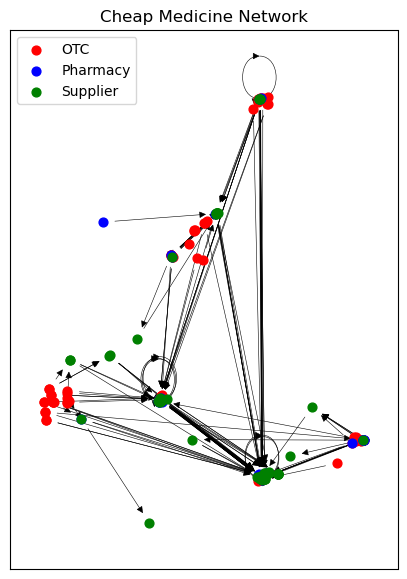

In [89]:
plt.rcParams["figure.figsize"] = (5,7)
#Create the network graph GMC
GMC, xxxx, codex, positions = makegraph_med(cheapdf, clist[0], clist[1], clist[2])
#Draw the graph
plt.title('Cheap Medicine Network')
drawgraph(GMC)

In [90]:
#Display map
drawmap(cheapdf, GMC)

### Intermediate Priced Medicine

In [91]:
idata = pharmacy_data
idata = idata.drop(columns =['S1','S2','S3','S7','S8','S9'])
interdf = idata[idata['Infor'].isin(['Pharmacy', 'OTC'])]
interdf = concatdf_med(interdf, idata, clist[3:6])
interdf

OID_  DI     Infor  latitude  longitude  Codes  \
0    114.0  F1  Pharmacy  6.686896  -1.607081      1   
1     64.0  F2  Pharmacy  6.670298  -1.590986      2   
2     94.0  F3       OTC  6.751693  -1.603975      3   
3     68.0  F4       OTC  6.705169  -1.618656      4   
4     37.0  F5       OTC  6.722547  -1.604707      5   
..     ...  ..       ...       ...        ...    ...   
185    0.0   0  Supplier  5.600167  -0.230468    218   
186    0.0   0  Supplier  5.626706   0.005751    223   
187    0.0   0  Supplier  5.564263  -0.220263    227   
188    0.0   0  Supplier  5.879465   0.174839    228   
189    0.0   0  Supplier  5.575025  -0.211214    229   

                             A7_Organisation_Name     S4   S5   S6  
0                                    MEK PHARMACY    0.0  0.0  0.0  
1                              Kwik save pharmacy  147.0  0.0  0.0  
2    David Akuoku Over the counter chemical store  129.0  0.0  0.0  
3                                  Aderic Chemist  181.0  0.0  0.0  
4                                 Rukaya Omar otc  171.0  0.0  0.0  
..                                            ...    ...  ...  ...  
185               Philips Pharmaceuticals Limited    0.0  0.0  0.0  
186                Bliss GV Pharma limited_Mumbai    0.0  0.0  0.0  
187                        Eskay Therapeutics Ltd    0.0  0.0  0.0  
188                           Life Sciences_Accra    0.0  0.0  0.0  
189          Amponsah Effah Pharmaceuticals_Accra    0.0  0.0  0.0  

[186 rows x 10 columns]

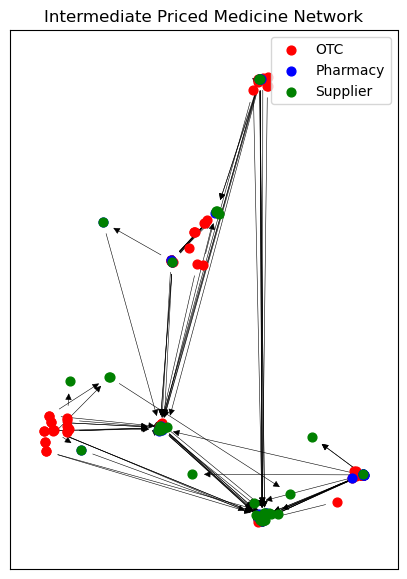

In [92]:
plt.rcParams["figure.figsize"] = (5,7)
#Create the network graph GIC, and drop the nodes without a connection
GMI, xxxx, codex, positions = makegraph_med(interdf, clist[3], clist[4], clist[5])

#Draw the graph
plt.title('Intermediate Priced Medicine Network')
drawgraph(GMI)

In [93]:
#Display map
drawmap(interdf, GMI)

### Expensive Medicine

In [94]:
#Drop Columns S1-S6
edata = pharmacy_data
edata = edata.drop(columns =['S1','S2','S3','S4','S5','S6'])
expdf = edata[edata['Infor'].isin(['Pharmacy', 'OTC'])]
expdf = concatdf_med(expdf, edata, clist[6:])
expdf

OID_   DI     Infor  latitude  longitude  Codes  \
0    114.0   F1  Pharmacy  6.686896  -1.607081      1   
1     64.0   F2  Pharmacy  6.670298  -1.590986      2   
2     94.0   F3       OTC  6.751693  -1.603975      3   
3     68.0   F4       OTC  6.705169  -1.618656      4   
4     37.0   F5       OTC  6.722547  -1.604707      5   
..     ...  ...       ...       ...        ...    ...   
160   58.0  R69  Supplier  5.690240  -0.030330    191   
161   65.0  R78  Supplier  9.395851  -0.846761    192   
162   67.0  R81  Supplier  5.633900  -0.172560    193   
163   45.0  R55  Supplier  5.547380  -0.209800    196   
164    0.0    0  Supplier  5.626706   0.005751    220   

                             A7_Organisation_Name     S7   S8   S9  
0                                    MEK PHARMACY    0.0  0.0  0.0  
1                              Kwik save pharmacy  147.0  0.0  0.0  
2    David Akuoku Over the counter chemical store    0.0  0.0  0.0  
3                                  Aderic Chemist    0.0  0.0  0.0  
4                                 Rukaya Omar otc    0.0  0.0  0.0  
..                                            ...    ...  ...  ...  
160                         Widama Pharmacy_Accra    0.0  0.0  0.0  
161                     Ernest Chemist Ltd_Tamale    0.0  0.0  0.0  
162              Ernest Chemist Ltd_Accra_Shiashi    0.0  0.0  0.0  
163                             Shagysco Pharmacy    0.0  0.0  0.0  
164                               Bliss GVS_Accra    0.0  0.0  0.0  

[165 rows x 10 columns]

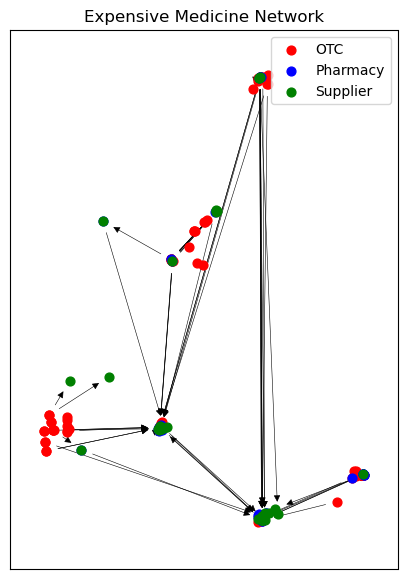

In [95]:
plt.rcParams["figure.figsize"] = (5,7)
#Create the network graph GEC
GME, xxxx, codex, positions = makegraph_med(expdf, clist[6], clist[7], clist[8])
#Draw the graph
plt.title('Expensive Medicine Network')
drawgraph(GME)

In [96]:
drawmap(expdf, GME)

## Table of  Network Attributes
We now have 10 different networks, includind the whole network, 6 regional sub-networks, and 3 medicine type sub-networks. Various functions to calculate network graph attributes are also created. To make the analysis easier to visualize, these attribute data are collected into a dataframe.

In [97]:
#function to calculate average degree of a graph
def avgdeg(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    avg = sum(x * y for x, y in zip(deg, cnt))/sum(cnt)
    return avg

In [98]:
graphlist = [G, G1, G2, G3, G4, G5, G6, GMC, GMI, GME] #current created graphs
numnodes = [G.number_of_nodes() for G in graphlist] #store number of nodes for each graph
numedges = [G.number_of_edges() for G in graphlist]
avgdegree = [avgdeg(G) for G in graphlist]
longestpl = [longestpath(G)[1] for G in graphlist]
shortestpl = [shortestpath(G)[1] for G in graphlist]
avgpl = [avglength(G) for G in graphlist]
avgclustering = [avgcc(G) for G in graphlist]
#number of node pairs with shortest path length(length =1), number of direct links
num_node_spl = [len(shortestpath(G)[0]) for G in graphlist]

In [99]:
#put all data into dataframe
attdata = {'Number of nodes': numnodes, 'Number of edges': numedges, 'Average Degree': avgdegree, 'Longest Path Length': longestpl, 'Shortest Path Length': shortestpl, 'Average Path Length': avgpl, 'Number of direct links': num_node_spl, 'Average Clustering Coefficient':avgclustering}
attdf = pd.DataFrame(attdata)
attdf['Name of Network']=['Whole Network', 'Upper East Region', 'Tamale Region', 'Volta region', 'Accra Region', 'Kumasi Region', 'Western North region', 'Cheap Medicine', 'Intermediate Priced Medicine', 'Expensive Medicine']
attdf = (attdf.set_index('Name of Network')).rename_axis(None, axis=0)
attdf

Number of nodes  Number of edges  \
Whole Network                             229              348   
Upper East Region                          61               88   
Tamale Region                              61               74   
Volta region                               51               65   
Accra Region                               53               67   
Kumasi Region                              64               77   
Western North region                       67               87   
Cheap Medicine                            201              230   
Intermediate Priced Medicine              186              134   
Expensive Medicine                        165               82   

                              Average Degree  Longest Path Length  \
Whole Network                       3.039301                    4   
Upper East Region                   2.885246                    3   
Tamale Region                       2.426230                    4   
Volta region                        2.549020                    4   
Accra Region                        2.528302                    4   
Kumasi Region                       2.406250                    3   
Western North region                2.597015                    4   
Cheap Medicine                      2.288557                    4   
Intermediate Priced Medicine        1.440860                    3   
Expensive Medicine                  0.993939                    2   

                              Shortest Path Length  Average Path Length  \
Whole Network                                    1             2.248434   
Upper East Region                                1             2.025974   
Tamale Region                                    1             2.520000   
Volta region                                     1             2.505495   
Accra Region                                     1             2.204082   
Kumasi Region                                    1             2.064103   
Western North region                             1             2.062500   
Cheap Medicine                                   1             2.244898   
Intermediate Priced Medicine                     1             1.442177   
Expensive Medicine                               1             1.012346   

                              Number of direct links  \
Whole Network                                     39   
Upper East Region                                 15   
Tamale Region                                      1   
Volta region                                       5   
Accra Region                                       5   
Kumasi Region                                      3   
Western North region                               9   
Cheap Medicine                                    22   
Intermediate Priced Medicine                      90   
Expensive Medicine                                80   

                              Average Clustering Coefficient  
Whole Network                                       0.009022  
Upper East Region                                   0.014364  
Tamale Region                                       0.000000  
Volta region                                        0.021736  
Accra Region                                        0.002830  
Kumasi Region                                       0.003460  
Western North region                                0.016828  
Cheap Medicine                                      0.000000  
Intermediate Priced Medicine                        0.002944  
Expensive Medicine                                  0.000000

In [100]:
#plot the path length attributes to compare
col1 = ['Longest Path Length', 'Shortest Path Length', 'Average Path Length']
df1 = attdf[col1]
df1

Longest Path Length  Shortest Path Length  \
Whole Network                                   4                     1   
Upper East Region                               3                     1   
Tamale Region                                   4                     1   
Volta region                                    4                     1   
Accra Region                                    4                     1   
Kumasi Region                                   3                     1   
Western North region                            4                     1   
Cheap Medicine                                  4                     1   
Intermediate Priced Medicine                    3                     1   
Expensive Medicine                              2                     1   

                              Average Path Length  
Whole Network                            2.248434  
Upper East Region                        2.025974  
Tamale Region                            2.520000  
Volta region                             2.505495  
Accra Region                             2.204082  
Kumasi Region                            2.064103  
Western North region                     2.062500  
Cheap Medicine                           2.244898  
Intermediate Priced Medicine             1.442177  
Expensive Medicine                       1.012346

In [101]:
#plot the node, links and direct links
col2 = ['Number of nodes', 'Number of edges', 'Number of direct links']
df2 = attdf[col2]
df2

Number of nodes  Number of edges  \
Whole Network                             229              348   
Upper East Region                          61               88   
Tamale Region                              61               74   
Volta region                               51               65   
Accra Region                               53               67   
Kumasi Region                              64               77   
Western North region                       67               87   
Cheap Medicine                            201              230   
Intermediate Priced Medicine              186              134   
Expensive Medicine                        165               82   

                              Number of direct links  
Whole Network                                     39  
Upper East Region                                 15  
Tamale Region                                      1  
Volta region                                       5  
Accra Region                                       5  
Kumasi Region                                      3  
Western North region                               9  
Cheap Medicine                                    22  
Intermediate Priced Medicine                      90  
Expensive Medicine                                80

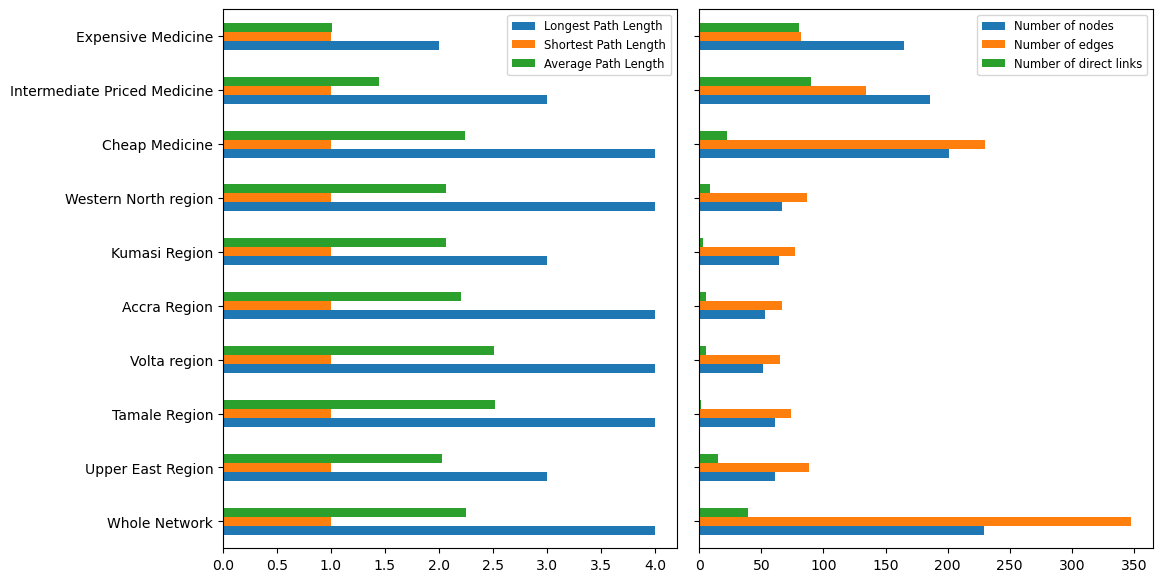

In [102]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 7))

df1.plot.barh(ax = ax1)
ax1.legend(fontsize='small')


df2.plot.barh(ax = ax2)
ax2.legend(fontsize='small')

plt.yticks(rotation=45)
plt.subplots_adjust(wspace=0.05)

## A useful 'search engine' to plot the supply chain of a node of interest
These few functions are implemented to conveniently display the supply chain of a specific node of interest. This enables a quick inspection of a specific retailer or supplier without the need to navigate through the spreadsheet. 

In [103]:
#generate the dataframe of node of interest 'chain' 
def single_node_sc(node):
    #extract the upper level nodes
    df = concatdf(pharmacy_data[pharmacy_data['Codes'] == node])
    
    if ((pharmacy_data['Codes'] == node) & pharmacy_data['Infor'].isin(['Pharmacy', 'OTC'])).all():
        fdf = df
    else :
        cols = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']
        df1 = pharmacy_data[pharmacy_data[cols].isin([node]).any(axis=1)] #df1 is the neighbors of the node
        df1[cols] = df1[cols].applymap(lambda x: 0 if x != node else x)
        
        supcodes = np.array(df1[df1['Infor'] == 'Supplier'].loc[:, 'Codes'])
        supcodes = supcodes[supcodes != node] #ignore the self-loop if theres any
    
        df2 = pharmacy_data[pharmacy_data[cols].isin(supcodes).any(axis=1)]#df2 is neighbors'neighbors
        df2[cols] = df2[cols].applymap(lambda x: x if x in supcodes else 0)
    
        fdf = pd.concat([df, df1, df2], ignore_index=True) #combine the dataframes
        fdf = fdf.drop_duplicates(subset='Codes', keep='first') #extra check incase theres duplicate rows

    return makegraph(fdf), fdf

In [104]:
#quickly get the name of the organization by its code
def getname(node):
    return pharmacy_data.loc[pharmacy_data['Codes'] == node, 'A7_Organisation_Name'].values[0]

In [105]:
#get the code of the organization by its name
def getcode(name):
    return pharmacy_data.loc[pharmacy_data['A7_Organisation_Name'] == name, 'Codes'].values[0]

In [106]:
#draw the node of interest 'chain' graph
def single_node_graph(node):
    name = getname(node)
    plt.title(f'{name}(Node {node}) in antimalarials supply chain')
    #serves as an extra marker that is a bit larger than the node itself to mark the node of interest
    nx.draw_networkx_nodes(G, positions, nodelist= codex[codex == node], node_color="orange",node_size=120, label='Node of interest')
    drawgraph(G)

In [107]:
#draw the map
def single_node_map(node):
    fdf = single_node_sc(node)[1]
    
    m = drawmap(fdf, G)
    #extra marker to highlight the node of interest
    for index, row in (fdf[fdf['Codes'] == node]).iterrows():
        folium.Marker(location=[row['latitude'], row['longitude']], 
                           icon=folium.Icon(color='orange', icon = 'star' , prefix='fa'),
                           popup=row['A7_Organisation_Name']).add_to(m)    
    return m

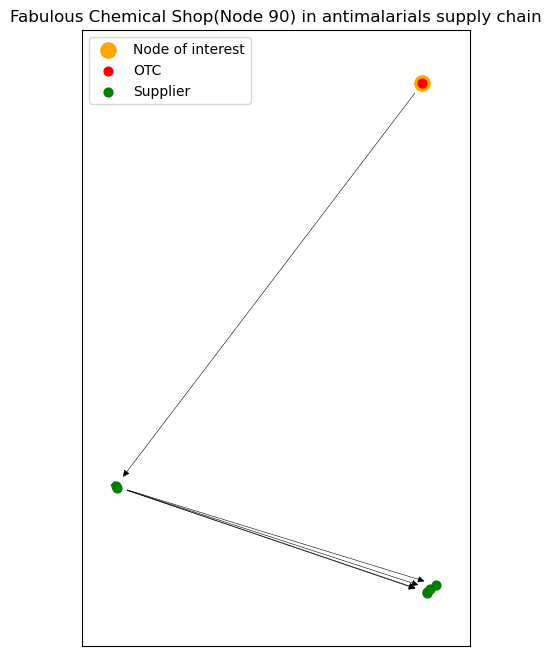

In [108]:
#To plot the graph and map of a node of interest in the supply chain,
#input the node code into [node =  ] and run this cell
node = 90
G, xxxx, codex, positions = single_node_sc(node)[0]
single_node_graph(node)
single_node_map(node)